In [1]:
import pandas as pd
import yfinance as yf
df = yf.download("HD", start = '2019-12-01', end = '2021-02-28')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-02,220.899994,221.190002,217.460007,217.619995,209.937347,4416300
2019-12-03,216.449997,216.449997,212.929993,214.000000,206.445145,6505400
2019-12-04,213.500000,214.960007,213.190002,214.100006,207.862640,4256200
2019-12-05,214.360001,214.500000,211.770004,213.000000,206.794678,4580500
2019-12-06,214.210007,215.360001,213.899994,214.279999,208.037384,4193700
...,...,...,...,...,...,...
2021-02-22,278.209991,278.489990,273.630005,275.850006,274.132172,3995500
2021-02-23,269.380005,269.670013,257.579987,267.239990,265.575775,12111000
2021-02-24,263.230011,266.989990,254.029999,259.970001,258.351074,14512700


In [2]:
def data_clipper(work_ar, line, tol):
    new_data = []
    for price in work_ar:
        if price>=line-tol and price<=line+tol:
            new_data.append(price)
    return new_data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
total_data = 1*np.array(df['Adj Close'])+0*np.array(df['Open'])
mean = np.nanmean(total_data)
work_ar_lower = []
work_ar_upper = []
for price in total_data:
    if price<=mean:
        work_ar_lower.append(price)
    else:
        work_ar_upper.append(price)
        
res = []
sup = []

for i in range(1, len(work_ar_upper)-1):
    diff = work_ar_upper[i]-work_ar_upper[i-1]
    check_diff = work_ar_upper[i+1]-work_ar_upper[i]
    if diff*check_diff<0:
        res.append(work_ar_upper[i])
        
for i in range(1, len(work_ar_lower)-1):
    diff = work_ar_lower[i]-work_ar_lower[i-1]
    check_diff = work_ar_lower[i+1]-work_ar_lower[i]
    if diff*check_diff<0:
        sup.append(work_ar_lower[i])

In [4]:
def filter_lines(tol):
    pivotstrength_r = []
    pivotstrength_s = []
    for r in res:
        new_data_res = data_clipper(work_ar_upper, r, tol) 
        strength_res = 0
        for i in range(1,len(new_data_res)-1):
            if ((new_data_res[i+1]-new_data_res[i])*(new_data_res[i]-new_data_res[i-1])<0):
                strength_res = strength_res+1
        pivotstrength_r.append(strength_res)
    for s in sup:
        new_data_sup = data_clipper(work_ar_lower, s, tol) 
        strength_sup = 0
        for i in range(1,len(new_data_sup)-1):
            if ((new_data_sup[i+1]-new_data_sup[i])*(new_data_sup[i]-new_data_sup[i-1])<0):
                strength_sup = strength_sup+1
        pivotstrength_s.append(strength_sup)
    ranked_res = pd.DataFrame(list(zip(res, pivotstrength_r)), columns = ['Resistance', 'Strength']) 
    ranked_sup = pd.DataFrame(list(zip(sup, pivotstrength_s)), columns = ['Support', 'Strength'])
    ranked_res = ranked_res.sort_values(by = 'Strength', ascending = False)
    ranked_sup = ranked_sup.sort_values(by = 'Strength', ascending = False)
    return ranked_res['Resistance'], ranked_sup['Support']

In [5]:
def spaced_out(res, sup, tol):
    filtered_res = [0]
    num_r = 0
    for i in range(len(res)):
        upper_limit_r = filtered_res[num_r]+tol
        lower_limit_r = filtered_res[num_r]-tol
        if (res[i]>filtered_res[num_r]):
            if (res[i]-tol)>(upper_limit_r):
                filtered_res.append(res[i])
                num_r = num_r + 1
        elif (res[i]<filtered_res[num_r]):
            if (res[i]+tol)<(lower_limit_r):
                filtered_res.append(res[i])
                num_r = num_r + 1
    filtered_sup = [0]
    num_s = 0
    for i in range(len(sup)):
        upper_limit_s = filtered_sup[num_s]+tol
        lower_limit_s = filtered_sup[num_s]-tol
        if (sup[i]>filtered_sup[num_s]):
            if (sup[i]-tol)>(upper_limit_s):
                filtered_sup.append(sup[i])
                num_s = num_s + 1
        elif (sup[i]<filtered_sup[num_s]):
            if (sup[i]+tol)<(lower_limit_s):
                filtered_sup.append(sup[i])
                num_s = num_s + 1
    filtered_res.pop(0)
    filtered_sup.pop(0)
    return filtered_res, filtered_sup

In [6]:
x = df.index.tolist()
plt.rcParams["figure.figsize"] = (20,20)
def plotting(n, plot_tolerance, check_tolerance): 
    list_res, list_sup = filter_lines(check_tolerance)
    plt.plot(x, total_data)
    resistance_store, support_store = spaced_out(list_res, list_sup, check_tolerance)
    for price in resistance_store[:n]:
        y = []
        for i in range(len(x)):
            y.append(price)
        plt.plot(x,y)
        for resi in y:
            plt.axhspan(resi-plot_tolerance, resi+plot_tolerance, color='yellow', alpha=0.5)
    for price in support_store[:n]:
        y = []
        for i in range(len(x)):
            y.append(price)
        plt.plot(x,y)
        for supp in y:
            plt.axhspan(supp-plot_tolerance, supp+plot_tolerance, color='pink', alpha=0.5)
    plt.show()
    return None

Enter number of lines supports / resistances you want on either side 4
Enter the number of units you want highlighted around the support or resistance line drawn 2
Enter the number of units you want around the support / resistance to be checked for pivot points in the past and in the future 5


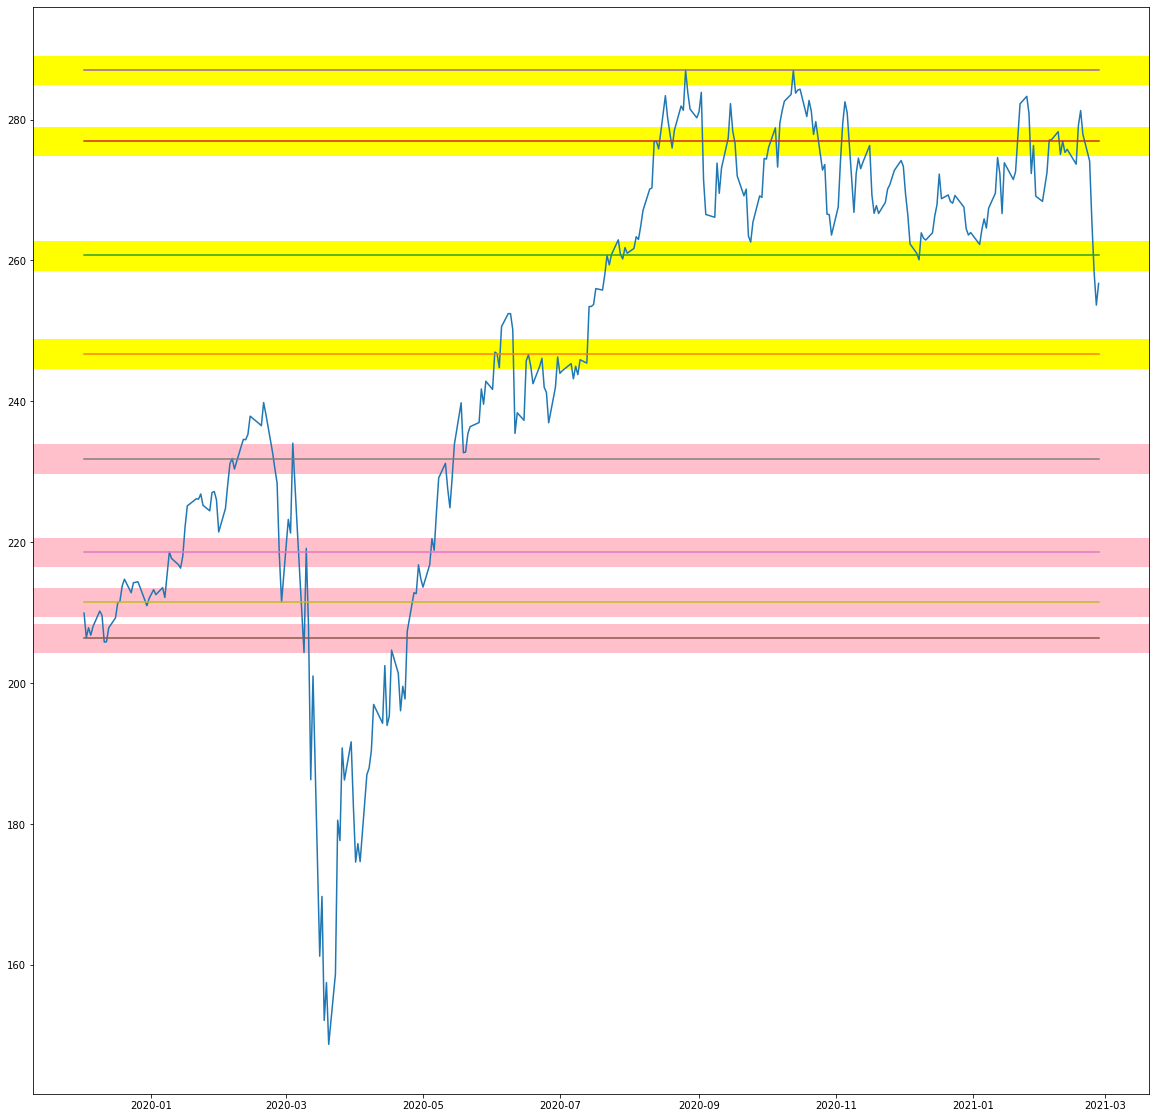

In [7]:
n = input('Enter number of lines supports / resistances you want on either side ')
plot_tolerance = input('Enter the number of units you want highlighted around the support or resistance line drawn ')
check_tolerance = input('Enter the number of units you want around the support / resistance to be checked for pivot points in the past and in the future ')
n = int(n)
plot_tolerance = int(plot_tolerance)
check_tolerance = int(check_tolerance)
plotting(n, plot_tolerance, check_tolerance)